In [88]:
import os
import glob
import numpy as np
import vtk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utilities import ReadVTUFile, ThresholdInBetween
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

In [89]:
path = "/Users/ana/Documents/AnahitaSeresti/03_MBFValidation/09.InterPatientAnalysis"
patient_metadata = glob.glob(f"{path}/*.xlsx")[0]
VTUFiles = glob.glob(f"{path}/*.vtu")
LabelFiles = glob.glob(f"{path}/*.dat")

In [90]:
PMD = pd.read_excel(patient_metadata)
print(PMD)
patient_ids = set(PMD['patient-id'])
print(patient_ids)

   patient-id stenosis tag FFR class  is-ischemic  FFR-Value
0         P03     post_LCx         0            0       0.96
1         P03      post_PL         0            0       0.96
2         P03          LAD        na            1        NaN
3         P04      post_PL         0            0       0.97
4         P04          LAD        na            1        NaN
5         P04          LCx        na            1        NaN
6         P06     post_LAD         0            0       0.89
7         P06          LCx         0            0       0.94
8         P06      post_PL         0            0       0.83
9         P10     post_LAD         0            0       0.83
10        P11     post_LAD         0            0       0.87
11        P11      post_PL         0            0       0.95
12        P13     post_LAD         1            1       0.75
13        P13     post_LCx         0            0       0.82
14        P16     post_LAD         1            1       0.75
15        P17     post_L

In [91]:
def ReadLabels(InputLabels, TerritoryTag):
    MBF_Labels = {}
    for tag in TerritoryTag:
        MBF_Labels[tag] =  []
    keys = list(MBF_Labels.keys())
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.split()
            for key in keys:
                if key == "LAD":
                    for k in ['LAD', 'Diag']:
                        if line[1].find(k)>=0: 
                            MBF_Labels[key].append(int(line[0]))
                elif key == "PL":
                    for k in ['PL', 'PDA']:
                        if line[1].find(k)>=0: 
                            MBF_Labels[key].append(int(line[0]))
                else:
                    if line[1].find(key)>=0: 
                        MBF_Labels[key].append(int(line[0]))

    MBF_Labels = {k:v for k,v in MBF_Labels.items() if len(v)>0}
    
    return MBF_Labels

def Normalize(MBF):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ArrayName = arrayname_
    ScalarArray = MBF.GetPointData().GetArray(ArrayName)
    per_75th = np.percentile(vtk_to_numpy(ScalarArray), 75)
    IndexMBFArray = ScalarArray/per_75th
    IndexMBF = numpy_to_vtk(IndexMBFArray)
    IndexMBF.SetName("IndexMBF")
    MBF.GetPointData().AddArray(IndexMBF)

    return MBF

def CollectMBFData(MBF, Labels):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
            arrayname_ = MBF.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    AbsMBFData = {}
    IndexMBFData = {}
    for key in Labels.keys():
        AbsMBFData[key] = np.array([])
        IndexMBFData[key] = np.array([])
        for i in Labels[key]:
            territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
            MBF_ = vtk_to_numpy(territory_.GetPointData().GetArray(ScalarArray))
            iMBF_ = vtk_to_numpy(territory_.GetPointData().GetArray("IndexMBF"))
            AbsMBFData[key] = np.append(AbsMBFData[key], MBF_)
            IndexMBFData[key] = np.append(IndexMBFData[key], iMBF_)
    

    return AbsMBFData, IndexMBFData

In [92]:
data = []
for id in patient_ids:
    print(id)
    tags = list(PMD[PMD['patient-id'] == id]['stenosis tag'])
    is_ischemic = list(PMD[PMD['patient-id'] == id]['is-ischemic'])
    FFR = list(PMD[PMD['patient-id'] == id]['FFR class'])
    FFRValue = list(PMD[PMD['patient-id'] == id]['FFR-Value'])
    for file in LabelFiles:
        if id in os.path.basename(os.path.splitext(file)[0]):
            Labels = file
    MBFLabels = ReadLabels(Labels, tags)
    for file in VTUFiles:
        if id in os.path.basename(os.path.splitext(file)[0]):
            MBF = Normalize(ReadVTUFile(file))
    AbsMBFData, IndexMBFData = CollectMBFData(MBF, MBFLabels)
    for i, t in enumerate(tags):
        data_ = {"patient_id": id, "tag": t}
        
        if is_ischemic[i] == 1:
            data_["is_ischemic"] = True
        else:
            data_["is_ischemic"] = False
        if FFR[i] == 1:
            data_["FFR"] = True
        elif FFR[i] == 0:
            data_["FFR"] = False
        else:
            data_["FFR"] = 'na'
        
        data_["FFRValue"] = FFRValue[i]
        data_["absMBF"] = AbsMBFData[t]
        data_["IndexMBF"] =  IndexMBFData[t]
        data_["MeanIndexMBF"] = np.mean(IndexMBFData[t])
        data.append(data_)

df = pd.DataFrame(data)
df



P17
P26
P23
P10
P20
P13
P32
P35
P42
P33
P24
P03
P11
P18
P38
P41
P04
P22
P39
P06
P16


,patient_id,tag,is_ischemic,FFR,FFRValue,absMBF,IndexMBF,MeanIndexMBF
0,P17,post_LAD,True,True,0.66,"[41.0, 31.0, 34.0, 25.0, 7.0, 4.0, 6.0, 5.0, 2...","[0.36936936936936937, 0.27927927927927926, 0.3...",0.827610
1,P17,PL,True,na,NaN,"[10.0, 16.0, 8.0, 14.0, 62.0, 66.0, 53.0, 56.0...","[0.09009009009009009, 0.14414414414414414, 0.0...",0.556080
2,P17,LCx,True,na,NaN,"[5.0, 4.0, 10.0, 8.0, 7.0, 5.0, 12.0, 8.0, 19....","[0.04504504504504504, 0.036036036036036036, 0....",0.881987
3,P26,post_LAD,True,True,0.60,"[167.0, 170.0, 164.0, 171.0, 139.0, 140.0, 129...","[1.1208053691275168, 1.1409395973154361, 1.100...",0.920153
4,P26,post_LCx,True,True,0.78,"[214.0, 209.0, 204.0, 204.0, 191.0, 186.0, 185...","[1.436241610738255, 1.4026845637583893, 1.3691...",0.956419
5,P26,post_PL,True,True,0.62,"[107.0, 107.0, 107.0, 107.0, 122.0, 118.0, 124...","[0.7181208053691275, 0.7181208053691275, 0.718...",0.763234
6,P23,post_LCx,False,False,0.96,"[135.0, 140.0, 140.0, 140.0, 137.0, 131.0, 133...","[0.9642857142857143, 1.0, 1.0, 1.0, 0.97857142...",0.877552
7,P10,post_LAD,False,False,0.83,"[126.0, 126.0, 126.0, 126.0, 114.0, 116.0, 114...","[0.5228215767634855, 0.5228215767634855, 0.522...",0.850714
8,P20,post_PL,False,False,0.81,"[18.0, 18.0, 18.0, 17.0, 35.0, 35.0, 35.0, 34....","[0.13138686131386862, 0.13138686131386862, 0.1...",0.824056
9,P20,LCx,True,na,NaN,"[99.0, 98.0, 97.0, 96.0, 108.0, 110.0, 109.0, ...","[0.7226277372262774, 0.7153284671532847, 0.708...",0.890542


In [ ]:
data = []
for id in patient_ids:
    print(id)
    tags = list(PMD[PMD['patient-id'] == id]['stenosis tag'])
    is_ischemic = list(PMD[PMD['patient-id'] == id]['is-ischemic'])
    FFR = list(PMD[PMD['patient-id'] == id]['FFR class'])
    for file in LabelFiles:
        if id in os.path.basename(os.path.splitext(file)[0]):
            Labels = file
    MBFLabels = ReadLabels(Labels, tags)
    for file in VTUFiles:
        if id in os.path.basename(os.path.splitext(file)[0]):
            MBF = Normalize(ReadVTUFile(file))
    AbsMBFData, IndexMBFData = CollectMBFData(MBF, MBFLabels)
    for i, t in enumerate(tags):
        data_ = {"patient_id": id, "tag": t, "is_ischemic": is_ischemic[i], "FFR": FFR[i], "absMBF": AbsMBFData[t], "IndexMBF": IndexMBFData[t]}
        data.append(data_)

df2 = pd.DataFrame(data)
df2

In [104]:
index_mbf_ischemic = np.concatenate(df[df['is_ischemic'] == True]['IndexMBF'].values)
q1, q2, q3 = np.percentile(index_mbf_ischemic, [25,50,75])
print(q1, q2, q3)
index_mbf_nonischemic = np.concatenate(df[df['is_ischemic'] == False]['IndexMBF'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic, [25,50,75])
print(q1, q2, q3)

index_mbf_FFR1 = np.concatenate(df[df["FFR"] == True]["IndexMBF"].values)
q1, q2, q3 = np.percentile(index_mbf_FFR1, [25,50,75])
print(q1, q2, q3)

index_mbf_FFR0 = np.concatenate(df[(df["FFR"] == False) & (df["is_ischemic"] == False)]["IndexMBF"].values)
q1, q2, q3 = np.percentile(index_mbf_FFR0, [25,50,75])
print(q1, q2, q3)


0.6134969325153374 0.8018018018018018 0.9798657718120806
0.6967213114754098 0.8467153284671532 1.0081967213114753
0.6666666666666666 0.8298969072164949 0.9924812030075187
0.6967213114754098 0.8467153284671532 1.0081967213114753


In [76]:
df_plot = pd.DataFrame({
    'IndexMBF': np.concatenate([index_mbf_ischemic, index_mbf_nonischemic, index_mbf_FFR1, index_mbf_FFR0]),
    'Group': ['Ischemic Territories']*len(index_mbf_ischemic) +
            ['Nonischemic Territories']*len(index_mbf_nonischemic) +
            ['Flow-limiting Stnosis']*len(index_mbf_FFR1) +
            ['Insignificant Stenosis']*len(index_mbf_FFR0), 
    'Type': ['Perfusion']*(len(index_mbf_ischemic )+ len(index_mbf_nonischemic)) + ['FFR']*(len(index_mbf_FFR1) + len(index_mbf_FFR0))
})



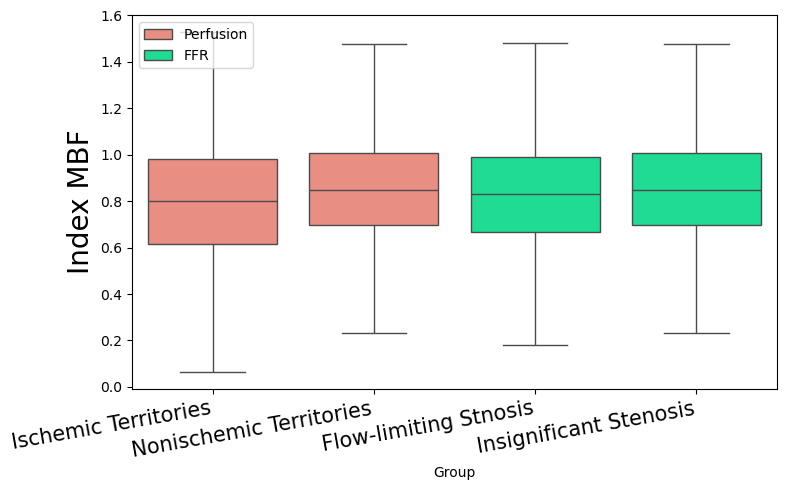

In [53]:
plt.figure(figsize=(8, 5))

ax = sns.boxplot(x='Group', y='IndexMBF', hue='Type', data= df_plot, showfliers=False, palette={'Perfusion':'salmon', 'FFR':'mediumspringgreen'})

ax.set_ylabel("Index MBF", fontsize = 20)
plt.setp(ax.get_xticklabels(), rotation=10, ha='right', fontsize = 15)
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [93]:
#average_index_mbf = np.array([np.mean(x) for x in df[df["FFR"] != 'na']['IndexMBF'].values])
average_index_mbf = np.array([x for x in df[df["FFR"] != 'na']['MeanIndexMBF']])

In [94]:
FFRvalues = np.array([x for x in df[df["FFR"] != 'na']['FFRValue']])
FFRvalues

array([0.66, 0.6 , 0.78, 0.62, 0.96, 0.83, 0.81, 0.75, 0.82, 0.73, 0.84,
       0.9 , 0.82, 0.86, 0.88, 0.84, 0.9 , 0.96, 0.96, 0.87, 0.95, 0.88,
       0.93, 0.54, 0.97, 0.86, 0.83, 0.9 , 0.89, 0.94, 0.83, 0.75])

In [95]:
from scipy.stats import pearsonr, linregress

print(pearsonr(FFRvalues, average_index_mbf))

PearsonRResult(statistic=0.3272010707724647, pvalue=0.06755341295415107)


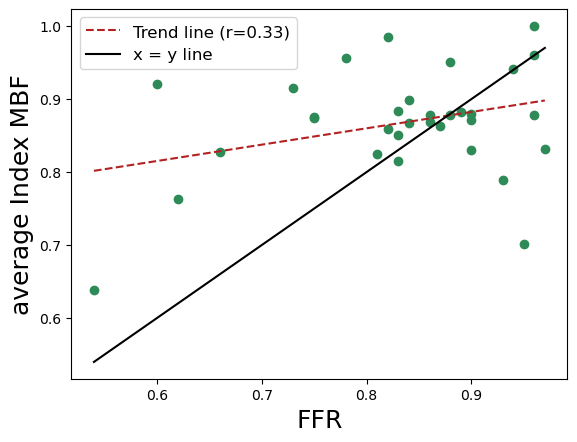

In [103]:
plt.scatter(FFRvalues, average_index_mbf, color = 'seagreen')

slope, intercept, _, _, _ = linregress(FFRvalues, average_index_mbf)
x_fit = np.linspace(min(FFRvalues), max(FFRvalues), 100)
y_fit = slope * x_fit + intercept

plt.plot(x_fit, y_fit, '--', color = 'firebrick', label=f"Trend line (r={pearsonr(FFRvalues, average_index_mbf)[0]:.2f})")
plt.plot(x_fit, x_fit, 'k-', label="x = y line")

plt.xlabel("FFR", fontsize = 18)
plt.ylabel("average Index MBF", fontsize = 18)
plt.legend(fontsize = 12)

plt.show()
